# Simulasi Penataan Kontainer Kapal

Notebook ini mensimulasikan penataan kontainer berdasarkan kategori berat (berat/sedang/ringan) dan tujuan pelabuhan (Makassar, Ambon, Jayapura), dengan aturan:

- Kontainer berat ditempatkan di bawah, sedang di tengah, ringan di atas.
- Aksesibilitas bongkar: kontainer untuk pelabuhan awal harus lebih mudah diakses (lebih atas) dibanding pelabuhan akhir.
- Kapasitas contoh: 450 kontainer, dibagi ke 9 bay, masing-masing 50 slot (10 stack × 5 tier).

Visualisasi menggunakan color coding:
- Hijau: ringan
- Kuning: sedang
- Merah: berat

Silakan jalankan sel-sel di bawah berurutan.


In [445]:
# Setup: impor dan utilitas
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

In [446]:
# Set random seed untuk konsistensi
random.seed(42)
np.random.seed(42)

# Konstanta kategori berat
WEIGHT_CATEGORIES = ["light", "medium", "heavy"]
WEIGHT_TO_COLOR = {"light": "#2ecc71", "medium": "#f1c40f", "heavy": "#e74c3c"}
WEIGHT_PRIORITY = {"heavy": 0, "medium": 1, "light": 2}  # untuk stacking bottom-up

@dataclass
class Container:
    id: int
    dest: str
    weight_cat: str
    weight_ton: float

@dataclass
class Position:
    bay: int
    stack: int
    tier: int

In [447]:
# Parameter simulasi
MAKASSAR_CONTAINER = 312
AMBON_CONTAINER = 262
JAYAPURA_CONTAINER = 176
TOTAL_CONTAINERS = MAKASSAR_CONTAINER + AMBON_CONTAINER + JAYAPURA_CONTAINER
BAYS = 18
STACKS_PER_BAY = 7
TIERS_PER_STACK = 6

PORTS = ["Makassar", "Ambon", "Jayapura"]
ALLOCATION_PER_PORT = {
    "Makassar": MAKASSAR_CONTAINER,
    "Ambon": AMBON_CONTAINER,
    "Jayapura": JAYAPURA_CONTAINER,
}

WEIGHT_MIX = {
    "Makassar": {"light": 0.6, "medium": 0.3, "heavy": 0.1},
    "Ambon": {"light": 0.3, "medium": 0.5, "heavy": 0.2},
    "Jayapura": {"light": 0.3, "medium": 0.6, "heavy": 0.1},
}

WEIGHT_RANGES = {
    "light": (8.0, 12.9),
    "medium": (13.0, 19.9),
    "heavy": (20.0, 25.0),
}

DEST_TO_ABBR = {"Makassar": "M", "Ambon": "A", "Jayapura": "J"}
WEIGHT_ABBR = {"light": "L", "medium": "M", "heavy": "H"}

# Generate Container

In [448]:
def normalize_mix(mix: Dict[str, float]) -> Dict[str, float]:
    total = sum(mix.values())
    if total == 0:
        n = len(mix)
        return {k: 1.0 / n for k in mix}
    return {k: v / total for k, v in mix.items()}

def generate_containers(total: int, allocation_per_port: Dict[str, int], 
                       weight_mix: Dict[str, Dict[str, float]]) -> List[Container]:
    containers: List[Container] = []
    container_id = 1
    
    for port, count in allocation_per_port.items():
        mix = normalize_mix(weight_mix.get(port, {c: 1/3 for c in WEIGHT_CATEGORIES}))
        probs = [mix.get("light", 0), mix.get("medium", 0), mix.get("heavy", 0)]
        cat_counts = np.random.multinomial(count, probs)
        cats = ["light", "medium", "heavy"]
        
        for cat, c in zip(cats, cat_counts):
            for _ in range(c):
                wmin, wmax = WEIGHT_RANGES[cat]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=port, weight_cat=cat, weight_ton=w))
                container_id += 1
    
    # Adjust jika tidak pas
    if len(containers) != total:
        if len(containers) > total:
            containers = containers[:total]
        else:
            while len(containers) < total:
                wmin, wmax = WEIGHT_RANGES["light"]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=PORTS[-1], weight_cat="light", weight_ton=w))
                container_id += 1
    
    return containers

In [449]:
def edges_in_bay_order(bays: int) -> List[int]:
    """Generate bay order dari pinggir ke tengah"""
    order = []
    left = 0
    right = bays - 1
    while left <= right:
        if left == right:
            order.append(left)
        else:
            order.append(left)
            order.append(right)
        left += 1
        right -= 1
    return order

def center_out_stack_order(stacks_per_bay: int) -> List[int]:
    """Generate stack order dari tengah ke pinggir"""
    order = []
    center = stacks_per_bay // 2
    order.append(center)
    
    for i in range(1, center + 1):
        if center - i >= 0:
            order.append(center - i)
        if center + i < stacks_per_bay:
            order.append(center + i)
    
    return order

def auto_allocate_port_to_bays(ports_order: List[str], allocation_per_port: Dict[str, int],
                              bays: int, stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, List[int]]:
    capacity_per_bay = stacks_per_bay * tiers_per_stack
    bay_need = {p: int(np.ceil(allocation_per_port.get(p, 0) / capacity_per_bay)) for p in ports_order}
    
    for p in ports_order:
        if allocation_per_port.get(p, 0) > 0 and bay_need[p] == 0:
            bay_need[p] = 1
    
    bay_sequence = edges_in_bay_order(bays)
    result: Dict[str, List[int]] = {p: [] for p in ports_order}
    idx = 0
    
    for p in ports_order:
        need = bay_need[p]
        result[p] = sorted(bay_sequence[idx: idx + need])
        idx += need
    
    if idx < bays and ports_order:
        result[ports_order[-1]].extend(bay_sequence[idx:])
        result[ports_order[-1]] = sorted(result[ports_order[-1]])
    
    return result

def can_place_container(assignment: Dict[Tuple[int,int,int], Container], 
                       bay: int, stack: int, tier: int, container: Container,
                       tiers_per_stack: int) -> bool:
    """Cek apakah kontainer bisa ditempatkan tanpa melanggar aturan berat"""
    # Cek kontainer di bawah
    if tier > 0:
        lower_pos = (bay, stack, tier - 1)
        if lower_pos not in assignment:
            return False  # Harus ada kontainer di bawah
        lower_cont = assignment[lower_pos]
        if WEIGHT_PRIORITY[container.weight_cat] < WEIGHT_PRIORITY[lower_cont.weight_cat]:
            return False  # Kontainer berat tidak boleh di atas kontainer ringan
    
    # Cek kontainer di atas
    if tier < tiers_per_stack - 1:
        upper_pos = (bay, stack, tier + 1)
        if upper_pos in assignment:
            upper_cont = assignment[upper_pos]
            if WEIGHT_PRIORITY[container.weight_cat] > WEIGHT_PRIORITY[upper_cont.weight_cat]:
                return False  # Kontainer ringan tidak boleh di bawah kontainer berat
    
    return True

# Plan Stowage

In [450]:
def plan_stowage(containers, bays, stacks_per_bay, tiers_per_stack,
                ports_order, port_to_bays=None, fa_lambda=1.0):
    if port_to_bays is None:
        port_to_bays = {p: list(range(bays)) for p in ports_order}

    # Koordinat bay untuk momen longitudinal
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    
    # Group containers by destination
    by_port = {p: [] for p in ports_order}
    for c in containers:
        if c.dest in by_port:
            by_port[c.dest].append(c)

    assignment = {}
    bay_stack_weights = {bay: [0.0]*stacks_per_bay for bay in range(bays)}
    bay_stack_fill = {bay: [0]*stacks_per_bay for bay in range(bays)}
    bay_total_weight = {bay: 0.0 for bay in range(bays)}
    
    # Stack order dari tengah ke pinggir
    stack_order = center_out_stack_order(stacks_per_bay)

    def current_fa_balance():
        """Calculate current front-aft balance ratio"""
        total_weight = sum(bay_total_weight.values())
        if total_weight == 0:
            return 0.0
        
        front_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] < 0)
        aft_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] > 0)
        center_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] == 0)
        
        # Distribute center weight equally
        front_weight += center_weight / 2
        aft_weight += center_weight / 2
        
        if front_weight + aft_weight == 0:
            return 0.0
        return abs(front_weight - aft_weight) / (front_weight + aft_weight)

    def get_fa_side_preference():
        """Determine which side (front/aft) needs more weight"""
        front_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] < 0)
        aft_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] > 0)
        center_weight = sum(bay_total_weight[b] for b in range(bays) if bay_coords[b] == 0)
        
        front_weight += center_weight / 2
        aft_weight += center_weight / 2
        
        if front_weight < aft_weight:
            return "front"  # Need more weight in front
        elif front_weight > aft_weight:
            return "aft"    # Need more weight in aft
        else:
            return "balanced"

    # Proses dari port terakhir ke pertama (LIFO)
    for port in ports_order[::-1]:
        port_conts = sorted(by_port.get(port, []), key=lambda c: WEIGHT_PRIORITY[c.weight_cat])
        candidate_bays = port_to_bays.get(port, [])
        
        for cont in port_conts:
            best_score, best_position = None, None
            current_fa_ratio = current_fa_balance()
            fa_preference = get_fa_side_preference()
            
            # Cari posisi terbaik
            for b in candidate_bays:
                # Cek apakah ada slot di bay b
                if not any(bay_stack_fill[b][s] < tiers_per_stack for s in range(stacks_per_bay)):
                    continue
                
                # Prioritas stack dari tengah ke pinggir
                for s in stack_order:
                    if bay_stack_fill[b][s] < tiers_per_stack:
                        tier = bay_stack_fill[b][s]
                        
                        # Cek aturan berat
                        if can_place_container(assignment, b, s, tier, cont, tiers_per_stack):
                            # Simple scoring: prioritize FA balance
                            bay_coord = bay_coords[b]
                            
                            # Base score from stack weight
                            score = bay_stack_weights[b][s]
                            
                            # FA balance bonus/penalty
                            if fa_preference == "front" and bay_coord < 0:
                                score -= cont.weight_ton * 2  # Bonus for front placement
                            elif fa_preference == "aft" and bay_coord > 0:
                                score -= cont.weight_ton * 2  # Bonus for aft placement
                            elif fa_preference == "balanced":
                                score -= cont.weight_ton * 0.5  # Small bonus for any placement
                            
                            # Penalty for wrong side placement
                            if fa_preference == "front" and bay_coord > 0:
                                score += cont.weight_ton * 1  # Penalty for aft when need front
                            elif fa_preference == "aft" and bay_coord < 0:
                                score += cont.weight_ton * 1  # Penalty for front when need aft
                            
                            if best_score is None or score < best_score:
                                best_score = score
                                best_position = (b, s, tier)
            
            # Tempatkan kontainer
            if best_position is not None:
                best_bay, target_stack, target_tier = best_position
                assignment[(best_bay, target_stack, target_tier)] = cont
                bay_stack_fill[best_bay][target_stack] += 1
                bay_stack_weights[best_bay][target_stack] += cont.weight_ton
                bay_total_weight[best_bay] += cont.weight_ton

    return assignment

# Evaluate Balance

In [451]:
def compute_weight_tensors(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                          stacks_per_bay: int, tiers_per_stack: int):
    W = np.zeros((bays, stacks_per_bay, tiers_per_stack), dtype=float)
    for (bay, stack, tier), c in assignment.items():
        W[bay, stack, tier] = c.weight_ton
    return W

def evaluate_balance(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                    stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, float]:
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total = W.sum()

    # Koordinat
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_coords = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)

    X = bay_coords[:, None, None]
    Y = stack_coords[None, :, None]

    # Left-Right balance
    left_mask = (Y < 0).astype(float) + 0.5*(Y == 0).astype(float)
    right_mask = (Y > 0).astype(float) + 0.5*(Y == 0).astype(float)
    left = float((W * left_mask).sum())
    right = float((W * right_mask).sum())
    lr_diff = abs(left - right)
    lr_ratio = lr_diff / total if total > 0 else 0.0

    # Front-Aft balance
    front_mask = (X < 0).astype(float) + 0.5*(X == 0).astype(float)
    aft_mask = (X > 0).astype(float) + 0.5*(X == 0).astype(float)
    front = float((W * front_mask).sum())
    aft = float((W * aft_mask).sum())
    fa_diff = abs(front - aft)
    fa_ratio = fa_diff / total if total > 0 else 0.0

    # Vertical balance
    bottom = W[:, :, :tiers_per_stack//2].sum()
    top = W[:, :, tiers_per_stack//2:].sum()
    vt_diff = abs(bottom - top)
    vt_ratio = vt_diff / total if total > 0 else 0.0

    return {
        "total_weight_t": float(total),
        "left_t": float(left), "right_t": float(right), "lr_diff_t": float(lr_diff), "lr_imbalance_ratio": float(lr_ratio),
        "front_t": float(front), "aft_t": float(aft), "fa_diff_t": float(fa_diff), "fa_imbalance_ratio": float(fa_ratio),
        "bottom_t": float(bottom), "top_t": float(top), "vt_diff_t": float(vt_diff), "vt_imbalance_ratio": float(vt_ratio),
    }

def print_balance_report(metrics: Dict[str, float]):
    print(f"Total berat: {metrics['total_weight_t']:.1f} t")
    print("Kiri–Kanan (LR):")
    print(f"  Left: {metrics['left_t']:.1f} t | Right: {metrics['right_t']:.1f} t | Selisih: {metrics['lr_diff_t']:.1f} t ({metrics['lr_imbalance_ratio']*100:.2f}%)")
    print("Depan–Belakang (FA):")
    print(f"  Front: {metrics['front_t']:.1f} t | Aft: {metrics['aft_t']:.1f} t | Selisih: {metrics['fa_diff_t']:.1f} t ({metrics['fa_imbalance_ratio']*100:.2f}%)")
    print("Atas–Bawah (Vertical):")
    print(f"  Bottom: {metrics['bottom_t']:.1f} t | Top: {metrics['top_t']:.1f} t | Selisih: {metrics['vt_diff_t']:.1f} t ({metrics['vt_imbalance_ratio']*100:.2f}%)")

# Visualized all bay

In [ ]:
def visualize_all_bays_detailed(assignment: Dict[Tuple[int,int,int], Container], bays: int, 
                               stacks_per_bay: int, tiers_per_stack: int):
    """Visualisasi detail semua bay dengan side view per bay"""
    # Tentukan grid layout untuk subplot
    cols = 6  # 6 bay per baris
    rows = math.ceil(bays / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(24, rows * 3.8))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Calculate total weight per bay
    bay_weights = {}
    for bay in range(bays):
        bay_weights[bay] = 0.0
        for stack in range(stacks_per_bay):
            for tier in range(tiers_per_stack):
                pos = (bay, stack, tier)
                if pos in assignment:
                    bay_weights[bay] += assignment[pos].weight_ton
    
    for bay in range(bays):
        row_idx = bay // cols
        col_idx = bay % cols
        ax = axes[row_idx, col_idx]
        
        # Gambar bay sebagai side view (stack horizontal, tier vertikal)
        for stack in range(stacks_per_bay):
            for tier in range(tiers_per_stack):
                x = stack
                y = tier  # Tier 0 di bawah (y=0), tier 5 di atas (y=5)
                
                pos = (bay, stack, tier)
                if pos in assignment:
                    container = assignment[pos]
                    color = WEIGHT_TO_COLOR[container.weight_cat]
                    
                    # Gambar kotak kontainer
                    rect = plt.Rectangle((x-0.45, y-0.45), 0.9, 0.9, 
                                       facecolor=color, edgecolor='black', linewidth=1)
                    ax.add_patch(rect)
                    
                    # Label dengan ID, tujuan, kategori berat, dan berat
                    container_id = f"#{container.id}"
                    dest_abbr = DEST_TO_ABBR[container.dest]
                    weight_abbr = WEIGHT_ABBR[container.weight_cat]
                    weight_val = f"{container.weight_ton:.1f}"
                    
                    # Teks multi-line dengan ID container
                    label = f"{container_id}\n{dest_abbr}-{weight_abbr}\n{weight_val}t"
                    ax.text(x, y, label, ha='center', va='center', 
                           fontsize=6, fontweight='bold', color='black')
                else:
                    # Slot kosong
                    rect = plt.Rectangle((x-0.45, y-0.45), 0.9, 0.9, 
                                       facecolor='lightgray', edgecolor='gray', 
                                       linewidth=0.5, alpha=0.3)
                    ax.add_patch(rect)
        
        # Setting axis untuk bay ini dengan total berat
        ax.set_xlim(-0.5, stacks_per_bay - 0.5)
        ax.set_ylim(-0.5, tiers_per_stack - 0.5)
        ax.set_title(f'Bay {bay}\n({bay_weights[bay]:.0f} ton)', fontweight='bold', fontsize=10)
        ax.set_xlabel('Row')
        ax.set_ylabel('Tier')
        
        # Grid dan ticks
        ax.set_xticks(range(stacks_per_bay))
        ax.set_yticks(range(tiers_per_stack))
        ax.set_yticklabels([str(tiers_per_stack - 1 - i) for i in range(tiers_per_stack)])
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    # Sembunyikan subplot kosong jika ada
    for bay in range(bays, rows * cols):
        row_idx = bay // cols
        col_idx = bay % cols
        axes[row_idx, col_idx].axis('off')
    
    # Legend global dengan posisi yang lebih baik
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=f'{cat.capitalize()}') 
                      for cat, color in WEIGHT_TO_COLOR.items()]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99), 
              fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    # Title dan layout
    fig.suptitle('Container Stowage Plan - All Bays (Side View)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, right=0.85)  # Berikan ruang untuk legend
    plt.show()

def visualize_single_bay(assignment: Dict[Tuple[int,int,int], Container], bay_num: int,
                        stacks_per_bay: int, tiers_per_stack: int):
    """Visualisasi detail satu bay tertentu"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate total weight for this bay
    bay_weight = 0.0
    for stack in range(stacks_per_bay):
        for tier in range(tiers_per_stack):
            pos = (bay_num, stack, tier)
            if pos in assignment:
                bay_weight += assignment[pos].weight_ton
    
    for stack in range(stacks_per_bay):
        for tier in range(tiers_per_stack):
            x = stack
            y = tier
            
            pos = (bay_num, stack, tier)
            if pos in assignment:
                container = assignment[pos]
                color = WEIGHT_TO_COLOR[container.weight_cat]
                
                # Gambar kotak kontainer
                rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                   facecolor=color, edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                
                # Label detail dengan ID container
                dest_abbr = DEST_TO_ABBR[container.dest]
                weight_abbr = WEIGHT_ABBR[container.weight_cat]
                weight_val = f"{container.weight_ton:.1f}"
                container_id = f"#{container.id}"
                
                # Teks multi-line dengan info lengkap
                label = f"{container_id}\n{dest_abbr}-{weight_abbr}\n{weight_val}t"
                ax.text(x, y, label, ha='center', va='center', 
                       fontsize=10, fontweight='bold', color='black')
            else:
                # Slot kosong
                rect = plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                   facecolor='white', edgecolor='gray', 
                                   linewidth=1, alpha=0.5)
                ax.add_patch(rect)
                ax.text(x, y, 'Empty', ha='center', va='center', 
                       fontsize=8, color='gray', style='italic')
    
    ax.set_xlim(-0.5, stacks_per_bay - 0.5)
    ax.set_ylim(-0.5, tiers_per_stack - 0.5)
    ax.set_title(f'Bay {bay_num} - Detailed View ({bay_weight:.0f} ton)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Row', fontsize=12)
    ax.set_ylabel('Tier', fontsize=12)
    
    # Ticks dan labels
    ax.set_xticks(range(stacks_per_bay))
    ax.set_yticks(range(tiers_per_stack))
    ax.set_yticklabels([str(tiers_per_stack - 1 - i) for i in range(tiers_per_stack)])
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Legend di pojok kanan luar plot area
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=f'{cat.capitalize()}') 
                      for cat, color in WEIGHT_TO_COLOR.items()]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
              fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    # Atur layout: plot di kiri, legend di kanan
    plt.tight_layout()
    plt.subplots_adjust(right=0.7)  # Plot hanya ambil 70% lebar, sisanya untuk legend
    plt.show()

# Check Violations

In [453]:
def check_weight_violations(assignment: Dict[Tuple[int,int,int], Container], 
                           bays: int, stacks_per_bay: int, tiers_per_stack: int):
    """Cek pelanggaran aturan berat"""
    violations = []
    
    for bay in range(bays):
        for stack in range(stacks_per_bay):
            # Get containers in this stack, sorted by tier
            stack_containers = []
            for tier in range(tiers_per_stack):
                pos = (bay, stack, tier)
                if pos in assignment:
                    stack_containers.append((tier, assignment[pos]))
            
            # Check weight rule violations
            for i in range(len(stack_containers) - 1):
                lower_tier, lower_cont = stack_containers[i]
                upper_tier, upper_cont = stack_containers[i + 1]
                
                if WEIGHT_PRIORITY[upper_cont.weight_cat] < WEIGHT_PRIORITY[lower_cont.weight_cat]:
                    violations.append({
                        'bay': bay,
                        'stack': stack,
                        'lower_tier': lower_tier,
                        'upper_tier': upper_tier,
                        'lower_weight': lower_cont.weight_cat,
                        'upper_weight': upper_cont.weight_cat
                    })
    
    return violations

# GM Report

In [454]:
# Parameter hidrostatik (DUMMY) — diset berdasarkan karakteristik feeder/container "SPIL RAHAYU"
# CATATAN: ini tetap dummy/estimasi. Ganti dengan data hidrostatis asli (hydrostatic table / offsets) bila tersedia.
# Satuan: ton, meter.
LIGHTSHIP_DISP_T = 4200.0 # berat lightship (estimasi untuk feeder ~120m, DWT 8200 => lightship ≈ 4.2k t)
LIGHTSHIP_KG_M = 7.0 # estimasi CoG vertikal lightship (lebih tinggi untuk superstruktur/machinery)
LIGHTSHIP_LCG_M = 0.0 # LCG relatif titik nol (midship), dummy
LIGHTSHIP_TCG_M = 0.0 # TCG relatif centerline (asumsi simetris)
KB_M = 4.0 # estimasi jarak keel -> pusat daya apung (sedikit lebih tinggi daripada kapal kecil)
# Aproksimasi BM dari waterplane kotak (lihat catatan di bawah)
BM_TRANSVERSE_M = 8.8 # BMt default (fallback jika tidak pakai aproksimasi)
BM_LONGITUDINAL_M = 262.0 # BMl ≈ 262 m (panjang besar membuat BMl besar)

# tambahan/ubah di bagian konstanta (opsional)
USE_APPROX_BMl = True  # kalau True, hitung BMl aproksimasi; kalau False pakai BM_LONGITUDINAL_M

# Parameter geometri untuk aproksimasi BMt = I/∇ (opsional)
HYDRO_USE_APPROX_BMt = True
SHIP_LENGTH_M = 120.0 # perkiraan panjang waterline (m)
SHIP_BEAM_M = 22.0 # perkiraan lebar waterline (m)
WATERPLANE_COEFF = 0.70 # koefisien waterplane (I ≈ C_wp * L*B^3/12)
WATER_DENSITY_T_PER_M3 = 1.025 # densitas air laut (t/m^3)
# Geometri plan view (longitudinal & transverse)
BAY_PITCH_M = 6.06 # jarak antar bay 20' dalam meter
ROW_SPACING_M = 2.6 # jarak antar stack (row) dalam meter
# Geometri vertikal tier untuk menghitung KG muatan (container feeder)
TIER_HEIGHT_M = 2.6 # jarak antar tier (umum untuk 20'/40' stack)
TIER_BASE_Z_M = 3.0 # elevasi tier 0 dari keel (estimasi untuk deck height di feeder)

def compute_cargo_cog(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                       stacks_per_bay: int, tiers_per_stack: int) -> Tuple[float,float,float,float]:
    """Hitung total berat kargo dan CoG 3D (LCG, TCG, KG) dalam meter.
    - Koordinat longitudinal memakai pitch bay 20' aktual (BAY_PITCH_M), nol di midship.
    - Koordinat transverse memakai jarak antar stack ROW_SPACING_M, nol di centerline.
    - Koordinat vertikal KG dari elevasi tier (TIER_BASE_Z_M + tier*TIER_HEIGHT_M).
    """
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total_w = W.sum()
    if total_w == 0:
        return 0.0, 0.0, 0.0, 0.0

    # koordinat meter dengan nol di tengah
    bay_indices = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_indices = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)
    tier_z = np.array([TIER_BASE_Z_M + i*TIER_HEIGHT_M for i in range(tiers_per_stack)])

    b_idx, s_idx, t_idx = np.indices(W.shape)
    L = bay_indices[b_idx] * BAY_PITCH_M
    T = stack_indices[s_idx] * ROW_SPACING_M
    Z = tier_z[t_idx]

    LCG = float((W * L).sum() / total_w)
    TCG = float((W * T).sum() / total_w)
    KG  = float((W * Z).sum() / total_w)
    return float(total_w), LCG, TCG, KG


def _approx_BMt_I_over_disp(disp_total_t: float) -> float:
    """Aproksimasi BMt = I_T / ∇, dengan I_T ≈ C_wp * L * B^3 / 12 (m^4), ∇ dalam m^3.
    Mengembalikan BMt dalam meter.
    """
    if disp_total_t <= 0:
        return 0.0
    I_transverse = WATERPLANE_COEFF * SHIP_LENGTH_M * (SHIP_BEAM_M ** 3) / 12.0  # m^4
    volume_disp_m3 = disp_total_t / WATER_DENSITY_T_PER_M3  # m^3
    return float(I_transverse / volume_disp_m3)

def _approx_BMl_I_over_disp(disp_total_t: float) -> float:
    """Aproksimasi BMl = I_L / ∇, dengan I_L ≈ C_wp * B * L^3 / 12 (m^4).
    Mengembalikan BMl dalam meter. Gunakan hanya sebagai aproksimasi kasar.
    """
    if disp_total_t <= 0:
        return 0.0
    I_longitudinal = WATERPLANE_COEFF * SHIP_BEAM_M * (SHIP_LENGTH_M ** 3) / 12.0
    volume_disp_m3 = disp_total_t / WATER_DENSITY_T_PER_M3
    return float(I_longitudinal / volume_disp_m3)

def compute_GM(total_cargo_t: float, cargo_LCG: float, cargo_TCG: float, cargo_KG: float):
    """Gabungkan lightship + cargo untuk KG total dan hitung GMt/GMl.
    Mengembalikan: displacement total (ton), KG_total (m), GMt (m), GMl (m).
    """
    disp_total = LIGHTSHIP_DISP_T + total_cargo_t
    KG_total = (LIGHTSHIP_DISP_T*LIGHTSHIP_KG_M + total_cargo_t*cargo_KG) / disp_total if disp_total > 0 else 0.0

    BMt_use = _approx_BMt_I_over_disp(disp_total) if HYDRO_USE_APPROX_BMt else BM_TRANSVERSE_M

    if USE_APPROX_BMl:
        BMl_use = _approx_BMl_I_over_disp(disp_total)
    else:
        BMl_use = BM_LONGITUDINAL_M

    GMt = KB_M + BMt_use - KG_total
    GMl = KB_M + BMl_use - KG_total
    return disp_total, KG_total, GMt, GMl

def print_GM_report(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int):
    total_cargo_t, LCG, TCG, KG = compute_cargo_cog(assignment, bays, stacks_per_bay, tiers_per_stack)
    disp_total, KG_total, GMt, GMl = compute_GM(total_cargo_t, LCG, TCG, KG)

    # tentukan BMt yang dipakai
    BMt_use = _approx_BMt_I_over_disp(disp_total) if HYDRO_USE_APPROX_BMt else BM_TRANSVERSE_M
    bmt_label = "(approx)" if HYDRO_USE_APPROX_BMt else "(const)"

    # tentukan BMl yang dipakai
    if USE_APPROX_BMl:
        BMl_use = _approx_BMl_I_over_disp(disp_total)
        bml_label = "(approx)"
    else:
        BMl_use = BM_LONGITUDINAL_M
        bml_label = "(const)"

    print("=== Perhitungan GM SPIL RAHAYU ===")
    print(f"Cargo: {total_cargo_t:.1f} t | LCG: {LCG:.2f} m | TCG: {TCG:.2f} m | KG: {KG:.2f} m")
    print(f"Lightship: {LIGHTSHIP_DISP_T:.1f} t | KG: {LIGHTSHIP_KG_M:.2f} m")
    print(f"KB: {KB_M:.2f} m | BMt: {BMt_use:.2f} m {bmt_label} | BMl: {BMl_use:.2f} m {bml_label}")
    print(f"Displacement total: {disp_total:.1f} t | KG_total: {KG_total:.2f} m")
    print(f"GMt (transversal): {GMt:.2f} m")
    print(f"GMl (longitudinal): {GMl:.2f} m")

    # Threshold kasar
    status = "AMAN" if GMt > 0.5 else "RENTAN"
    print(f"Status transversal: {status}")
    
    # Analisis tambahan
    print(f"\n=== Analisis Detail ===")
    print(f"Volume displacement: {disp_total/WATER_DENSITY_T_PER_M3:.1f} m³")
    print(f"Freeboard effect: KG_total - KB = {KG_total - KB_M:.2f} m")

    if HYDRO_USE_APPROX_BMt:
        I_transverse = WATERPLANE_COEFF * SHIP_LENGTH_M * (SHIP_BEAM_M ** 3) / 12.0
        print(f"Moment of inertia transverse: {I_transverse:.1f} m⁴")

    if USE_APPROX_BMl:
        I_longitudinal = WATERPLANE_COEFF * SHIP_BEAM_M * (SHIP_LENGTH_M ** 3) / 12.0
        print(f"Moment of inertia longitudinal: {I_longitudinal:.1f} m⁴")

    print(f"Metacentric radius (BMt): {BMt_use:.2f} m")
    print(f"Metacentric radius (BMl): {BMl_use:.2f} m")


In [455]:
# Main execution
if __name__ == "__main__":
    print("=== Container Stowage Planning (Improved FA Balance) ===")
    
    # Generate containers
    containers = generate_containers(TOTAL_CONTAINERS, ALLOCATION_PER_PORT, WEIGHT_MIX)
    print(f"Generated {len(containers)} containers")
    
    # Auto allocate bays
    AUTO_PORT_TO_BAYS = auto_allocate_port_to_bays(PORTS, ALLOCATION_PER_PORT, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
    print("PORT_TO_BAYS (auto, outside-in):", AUTO_PORT_TO_BAYS)
    
    # Plan stowage with new FA balancing algorithm
    assignment = plan_stowage(containers, BAYS, STACKS_PER_BAY, TIERS_PER_STACK, PORTS, AUTO_PORT_TO_BAYS, fa_lambda=1.0)
    
    # Check violations
    violations = check_weight_violations(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
    print(f"\nWeight rule violations: {len(violations)}")
    if violations:
        for v in violations[:5]:  # Show first 5 violations
            print(f"  Bay {v['bay']}, Stack {v['stack']}: {v['upper_weight']} on {v['lower_weight']}")
    
    # Evaluate balance
    metrics = evaluate_balance(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
    print("\n=== Balance Report ===")
    print_balance_report(metrics)
    
    # Check utilization
    total_slots = BAYS * STACKS_PER_BAY * TIERS_PER_STACK
    used_slots = len(assignment)
    print(f"\nUtilization: {used_slots}/{total_slots} ({used_slots/total_slots*100:.1f}%)")

    # 🔹 Tambahkan laporan stabilitas hidrostatik
    print("\n=== Stability Report (Hydrostatics) ===")
    print_GM_report(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)

=== Container Stowage Planning (Improved FA Balance) ===
Generated 750 containers
PORT_TO_BAYS (auto, outside-in): {'Makassar': [0, 1, 2, 3, 14, 15, 16, 17], 'Ambon': [4, 5, 6, 7, 11, 12, 13], 'Jayapura': [8, 9, 10]}

Weight rule violations: 0

=== Balance Report ===
Total berat: 10485.0 t
Kiri–Kanan (LR):
  Left: 5262.1 t | Right: 5222.9 t | Selisih: 39.2 t (0.37%)
Depan–Belakang (FA):
  Front: 5239.4 t | Aft: 5245.6 t | Selisih: 6.2 t (0.06%)
Atas–Bawah (Vertical):
  Bottom: 6550.6 t | Top: 3934.4 t | Selisih: 2616.3 t (24.95%)

Utilization: 700/756 (92.6%)

=== Stability Report (Hydrostatics) ===
=== Perhitungan GM SPIL RAHAYU ===
Cargo: 10485.0 t | LCG: 0.03 m | TCG: -0.00 m | KG: 8.11 m
Lightship: 4200.0 t | KG: 7.00 m
KB: 4.00 m | BMt: 5.20 m (approx) | BMl: 154.79 m (approx)
Displacement total: 14685.0 t | KG_total: 7.79 m
GMt (transversal): 1.41 m
GMl (longitudinal): 150.99 m
Status transversal: AMAN

=== Analisis Detail ===
Volume displacement: 14326.8 m³
Freeboard effect: KG_

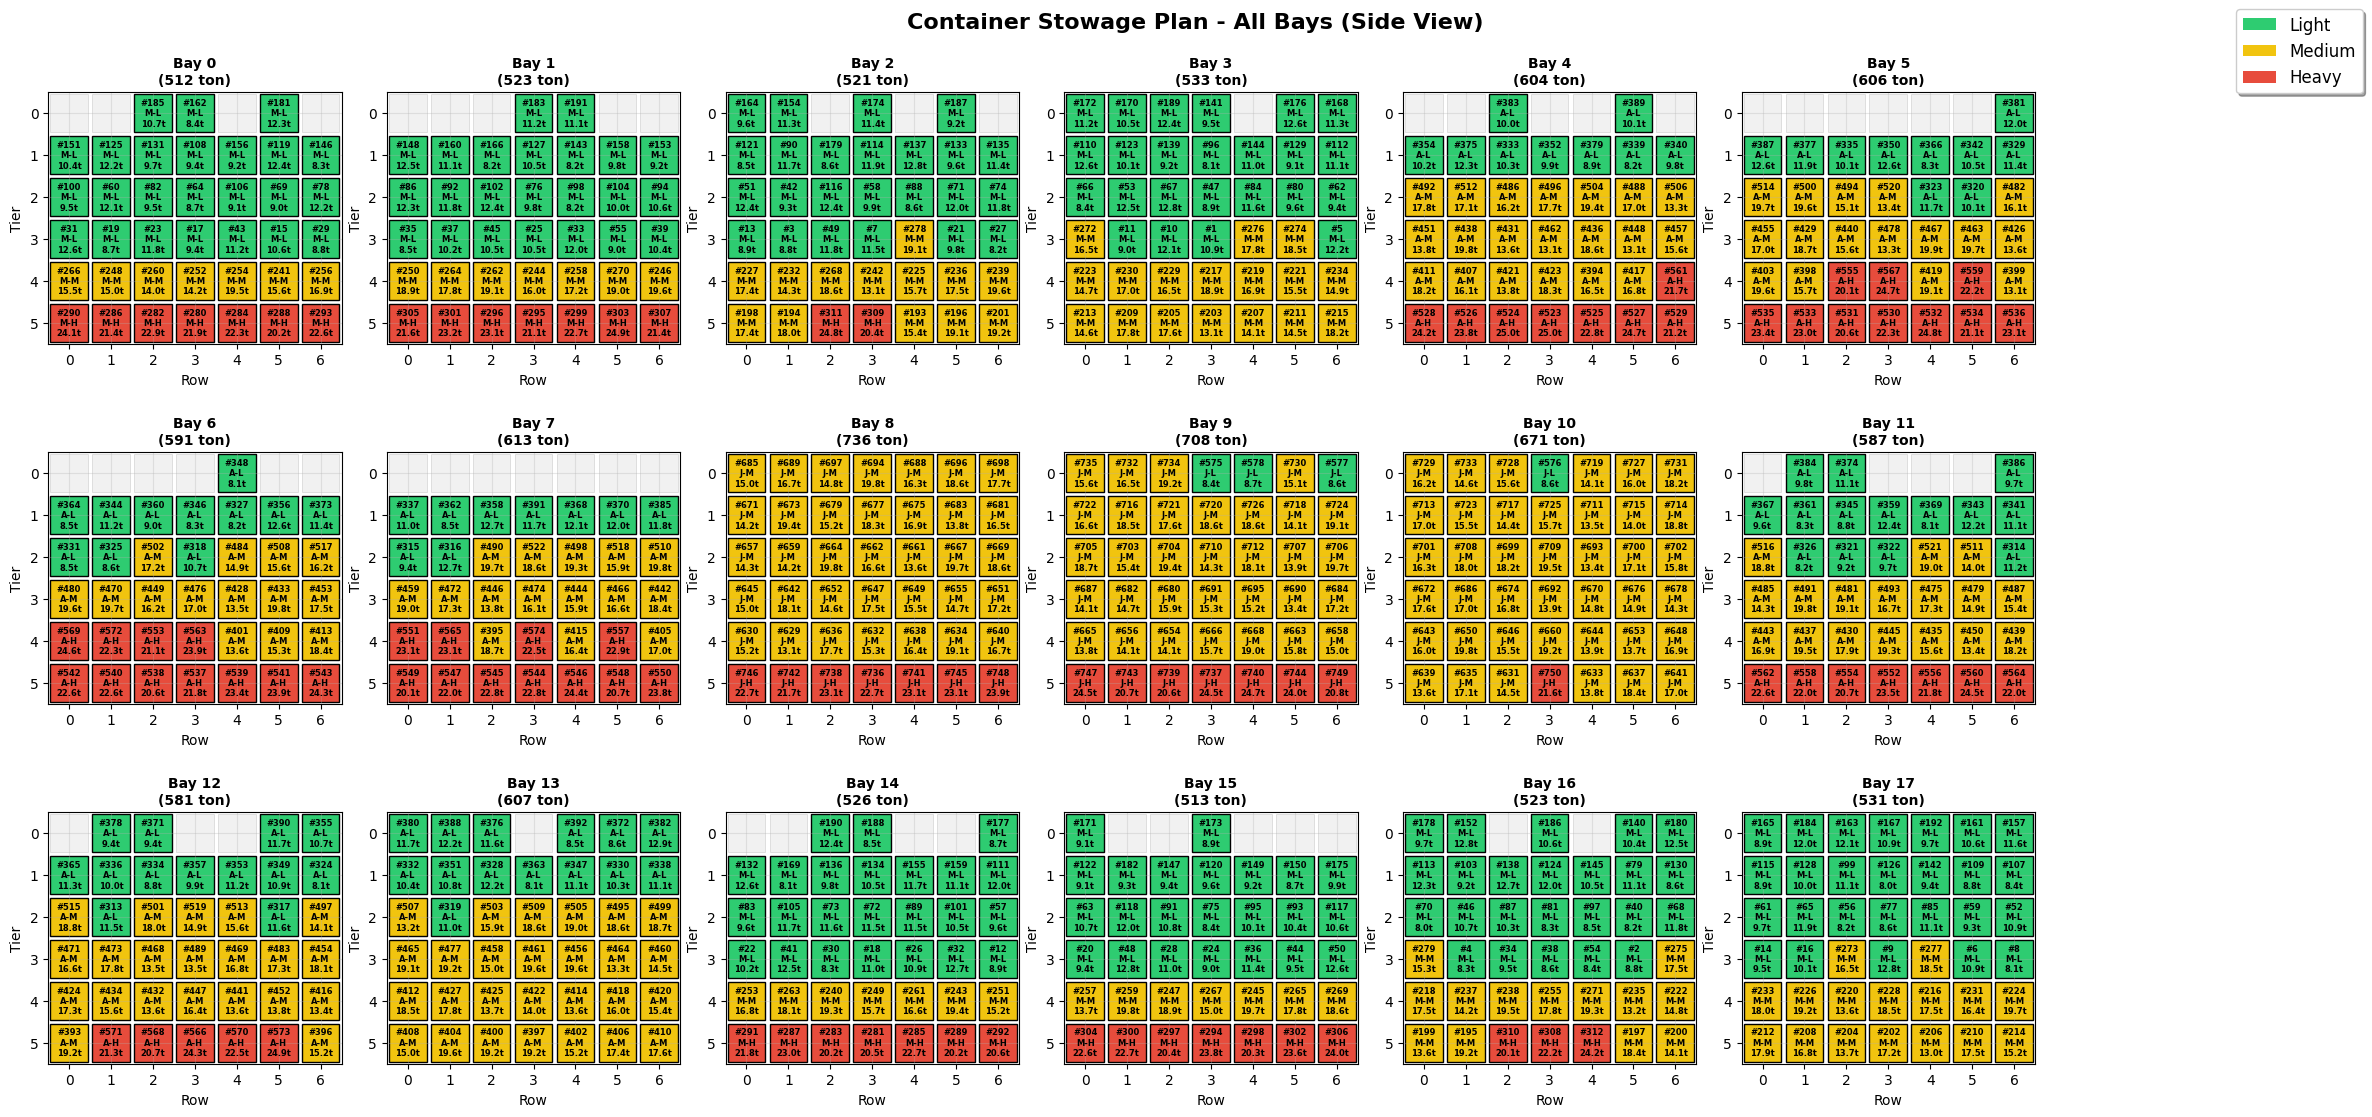

In [456]:
 # Visualize all bays
visualize_all_bays_detailed(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)


Showing detailed view of Bay 0:


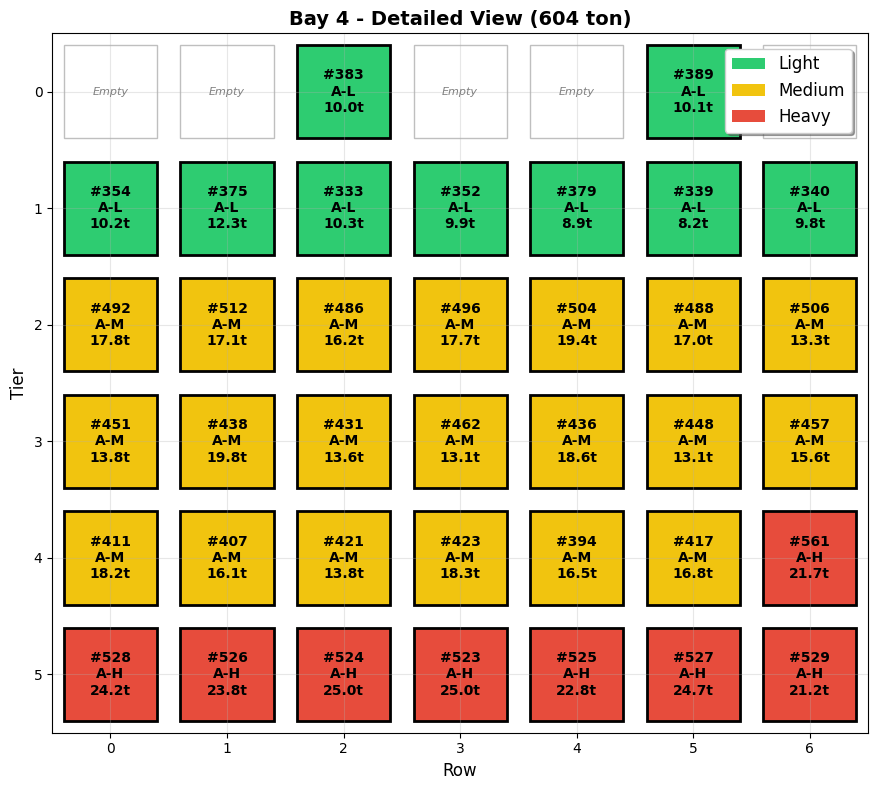

In [457]:
    # Visualize specific bay (example: bay 0)
print("\nShowing detailed view of Bay 0:")
visualize_single_bay(assignment, 4, STACKS_PER_BAY, TIERS_PER_STACK)